In [47]:
import random
import math
import time
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms

In [48]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [49]:
INPUT_PATH = "../input/cat-dataset/CAT_00"
img_path_list = glob.glob(os.path.join(INPUT_PATH,"*.jpg"))
print(len(img_path_list))

1706


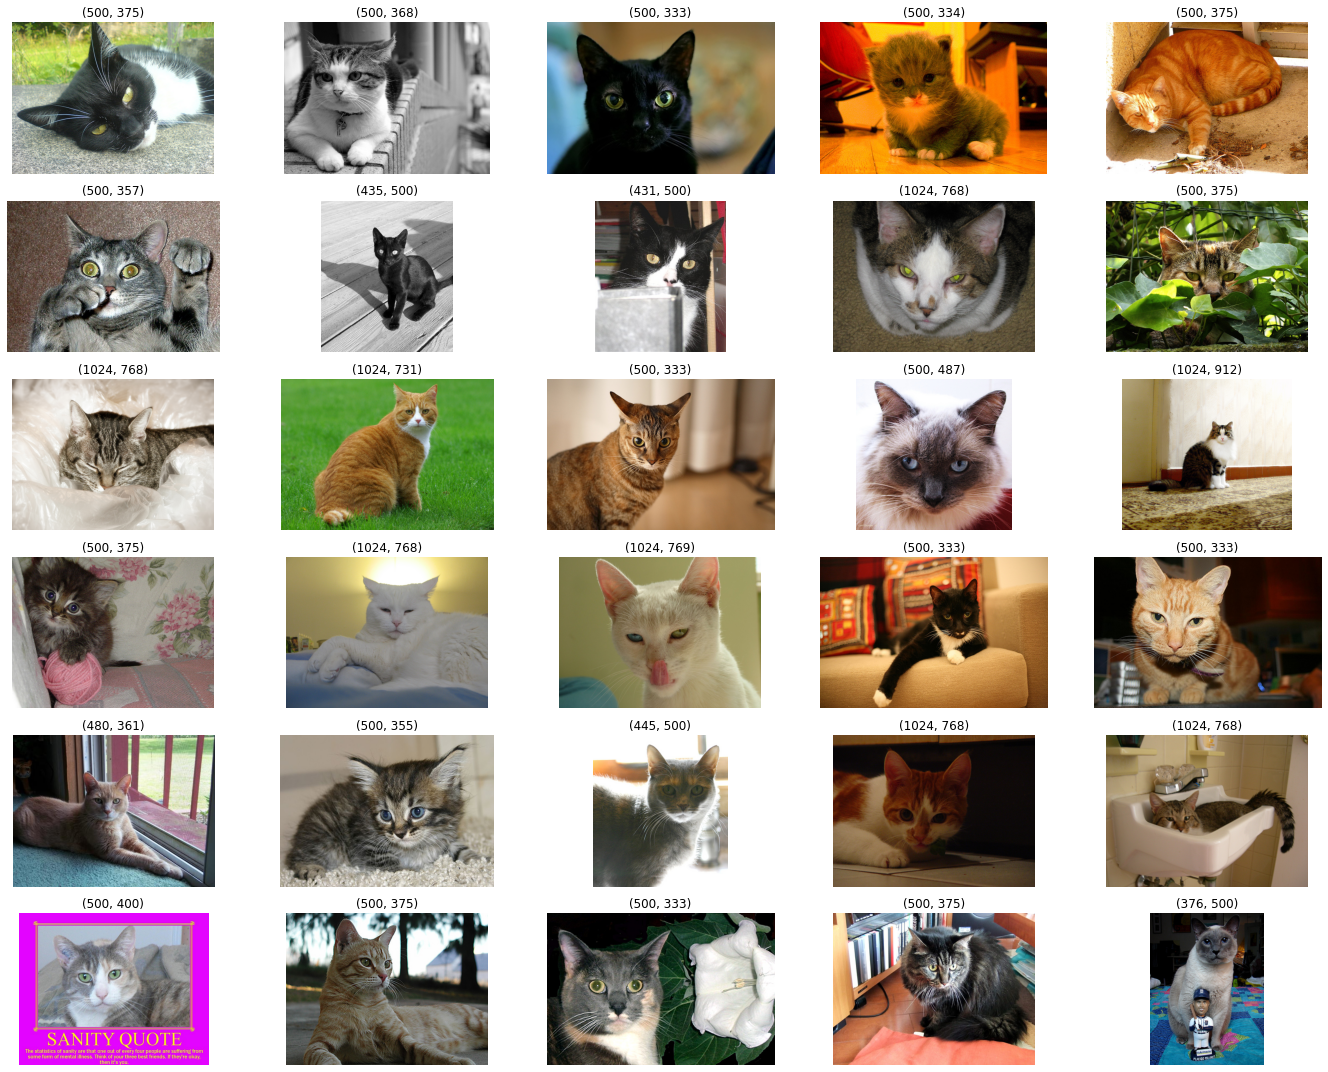

In [50]:
plt.figure(figsize=(20,15),tight_layout = True)
for i in range(30):
    plt.subplot(6,5,i+1)
    img = Image.open(img_path_list[i])
    plt.imshow(img)
    plt.axis("OFF")
    plt.title(img.size)

In [51]:
def seed_everything():
    torch.manual_seed(1234)
    np.random.seed(1234)
    random.seed(1234)
seed_everything() 

In [52]:
class Generator(nn.Module):
    def __init__(self, z_dim=20, image_size = 64):
        super(Generator, self).__init__()
        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(z_dim,
                               image_size*8,
                               kernel_size = 4,
                               stride = 1),
            nn.BatchNorm2d(image_size*8),
            nn.ReLU(inplace=True))

        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(image_size*8,
                               image_size*4,
                               kernel_size = 4,
                               stride = 2,
                               padding = 1),
            nn.BatchNorm2d(image_size*4),
            nn.ReLU(inplace=True))

        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 4, 
                               image_size * 2,
                               kernel_size=4, 
                               stride=2, 
                               padding=1),
            nn.BatchNorm2d(image_size * 2),
            nn.ReLU(inplace=True))

        self.layer4 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 2, 
                               image_size,
                               kernel_size=4, 
                               stride=2, 
                               padding=1),
            nn.BatchNorm2d(image_size),
            nn.ReLU(inplace=True))

        self.last = nn.Sequential(
            nn.ConvTranspose2d(image_size, 
                               3,
                               kernel_size=4,
                               stride=2, 
                               padding=1),
            nn.Tanh())

    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.last(out)
        return out

fake_img_shape:torch.Size([1, 3, 64, 64])


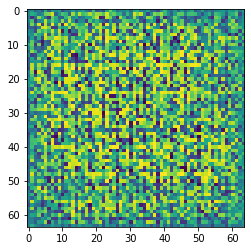

In [53]:
G = Generator(z_dim = 20, image_size = 64)
input_z = torch.randn(1,20)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1,1)
fake_images = G(input_z)
print(f"fake_img_shape:{fake_images.shape}")

# img_transformed = fake_images[0][0].detach().numpy()
# plt.imshow(img_transformed)
# plt.show()

In [54]:
class Discriminator(nn.Module):
    def __init__(self,image_size = 64):
        super(Discriminator, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,
                      image_size,
                      kernel_size = 4,
                      stride = 2,
                      padding = 1
                     ),
            nn.LeakyReLU(0.1, inplace = True))
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(image_size, 
                      image_size*2,
                      kernel_size = 4,
                      stride = 2,
                      padding = 1
                     ),
            nn.LeakyReLU(0.1, inplace = True))
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(image_size*2, 
                      image_size*4,
                      kernel_size = 4,
                      stride = 2,
                      padding = 1
                     ),
            nn.LeakyReLU(0.1, inplace = True))

        self.layer4 = nn.Sequential(
            nn.Conv2d(image_size*4, 
                      image_size*8,
                      kernel_size = 4,
                      stride = 2,
                      padding = 1
                     ),
            nn.LeakyReLU(0.1, inplace = True))
        self.last = nn.Conv2d(image_size*8, 1, kernel_size=4, stride=1)
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.last(out)
        return out

In [55]:
D = Discriminator(image_size=64)

input_z = torch.randn(1, 20)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
fake_images = G(input_z)

d_out = D(fake_images)

# print(nn.Sigmoid()(d_out))

tensor([[[[0.5033]]]], grad_fn=<SigmoidBackward>)


In [56]:
def make_img_path_list(use_dir_num):
    train_img_list = []
    for i in range(use_dir_num):
        use_dir = f"../input/cat-dataset/CAT_0{i}"
        paths = glob.glob(os.path.join(use_dir,"*.jpg"))
        train_img_list+=paths
        print("num_img",len(train_img_list))
    return train_img_list

In [57]:
train_img_list = make_img_path_list(7)


num_img 1706
num_img 3324
num_img 5081
num_img 5892
num_img 7288
num_img 8609
num_img 9997


In [58]:
# transform
IMG_MEAN = [0.5, 0.5, 0.5]
IMG_STD = [0.5, 0.5, 0.5]
size = (64,64)

data_transform = transforms.Compose([
    transforms.Resize(size),
    transforms.ToTensor(), 
    transforms.Normalize(mean=IMG_MEAN, std=IMG_STD),
])

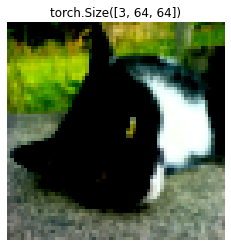

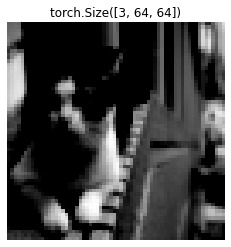

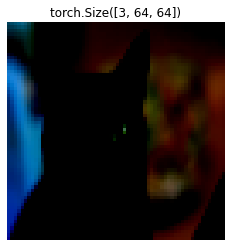

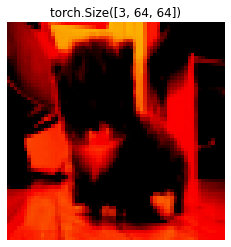

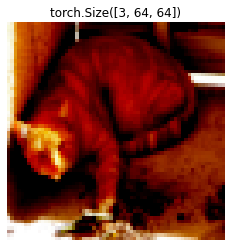

In [59]:
for i in range(5,10):
    img = Image.open(img_path_list[i])
    x = data_transform(img)
    plt.title(x.shape)
    plt.imshow(x.permute(1,2,0))
    plt.axis("off")
    plt.show()

In [60]:
# dataset class
class GAN_Dataset(data.Dataset):
    def __init__(self, file_list, transform):
        self.file_list = file_list
        self.transform = transform
    
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, index):
        img = Image.open(self.file_list[index])
        img = self.transform(img)
        return img

In [61]:
train_dataset = GAN_Dataset(
    file_list=train_img_list, 
    transform=data_transform)

batch_size = 64

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

batch_iterator = iter(train_dataloader) 
imges = next(batch_iterator) 
print(imges.size())

torch.Size([64, 3, 64, 64])


In [62]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [67]:
G_losses = []
D_losses = []
def train_model(G, D, dataloader, num_epochs,device):
    g_lr, d_lr = 0.0005, 0.0005
    beta1, beta2 = 0.1, 0.9
    g_optimizer = torch.optim.Adam(G.parameters(), g_lr, [beta1, beta2])
    d_optimizer = torch.optim.Adam(D.parameters(), d_lr, [beta1, beta2])

    criterion = nn.BCEWithLogitsLoss(reduction='mean')

    z_dim = 20
    mini_batch_size = 64

    G.to(device)
    D.to(device)

    G.train()  
    D.train() 

    torch.backends.cudnn.benchmark = True

    num_train_imgs = len(dataloader.dataset)
    batch_size = dataloader.batch_size

    iteration = 1
    logs = []

    for epoch in range(num_epochs):

        t_epoch_start = time.time()
        epoch_g_loss = 0.0  
        epoch_d_loss = 0.0 

        print('-------------')
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-------------')
        print('（train）')

        for imges in dataloader:

            if imges.size()[0] == 1:
                continue

            imges = imges.to(device)


            mini_batch_size = imges.size()[0]
            label_real = torch.full((mini_batch_size,), 1).to(device)
            label_fake = torch.full((mini_batch_size,), 0).to(device)

            d_out_real = D(imges)


            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images = G(input_z)
            d_out_fake = D(fake_images)

            label_real = label_real.type_as(d_out_real.view(-1))
            label_fake = label_fake.type_as(d_out_fake.view(-1))
            
            d_loss_real = criterion(d_out_real.view(-1), label_real)
            d_loss_fake = criterion(d_out_fake.view(-1), label_fake)
            d_loss = d_loss_real + d_loss_fake

            g_optimizer.zero_grad()
            d_optimizer.zero_grad()

            d_loss.backward()
            d_optimizer.step()


            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images = G(input_z)
            d_out_fake = D(fake_images)

            g_loss = criterion(d_out_fake.view(-1), label_real)

            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            iteration += 1
        G_losses.append(epoch_g_loss / batch_size)
        D_losses.append(epoch_d_loss / batch_size)
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_D_Loss:{:.4f} ||Epoch_G_Loss:{:.4f}'.format(
            epoch, epoch_d_loss/batch_size, epoch_g_loss/batch_size))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()

    return G, D

In [68]:

G = Generator(z_dim = 20, image_size = 64)
D = Discriminator(image_size=64)

G.apply(weights_init)
D.apply(weights_init)


num_epochs = 10
G_update, D_update = train_model(
    G, D, dataloader=train_dataloader, num_epochs=num_epochs, device = device)

ネットワークの初期化完了
-------------
Epoch 0/10
-------------
（train）
-------------
epoch 0 || Epoch_D_Loss:3.2032 ||Epoch_G_Loss:2.9623
timer:  104.8467 sec.
-------------
Epoch 1/10
-------------
（train）
-------------
epoch 1 || Epoch_D_Loss:3.3643 ||Epoch_G_Loss:2.2679
timer:  102.6096 sec.
-------------
Epoch 2/10
-------------
（train）
-------------
epoch 2 || Epoch_D_Loss:3.3567 ||Epoch_G_Loss:2.3267
timer:  101.8925 sec.
-------------
Epoch 3/10
-------------
（train）
-------------
epoch 3 || Epoch_D_Loss:3.3019 ||Epoch_G_Loss:2.5255
timer:  105.1416 sec.
-------------
Epoch 4/10
-------------
（train）
-------------
epoch 4 || Epoch_D_Loss:3.2468 ||Epoch_G_Loss:2.6572
timer:  103.1431 sec.
-------------
Epoch 5/10
-------------
（train）
-------------
epoch 5 || Epoch_D_Loss:3.1748 ||Epoch_G_Loss:2.8594
timer:  101.1906 sec.
-------------
Epoch 6/10
-------------
（train）
-------------
epoch 6 || Epoch_D_Loss:3.2439 ||Epoch_G_Loss:2.8026
timer:  100.4533 sec.
-------------
Epoch 7/10
----------

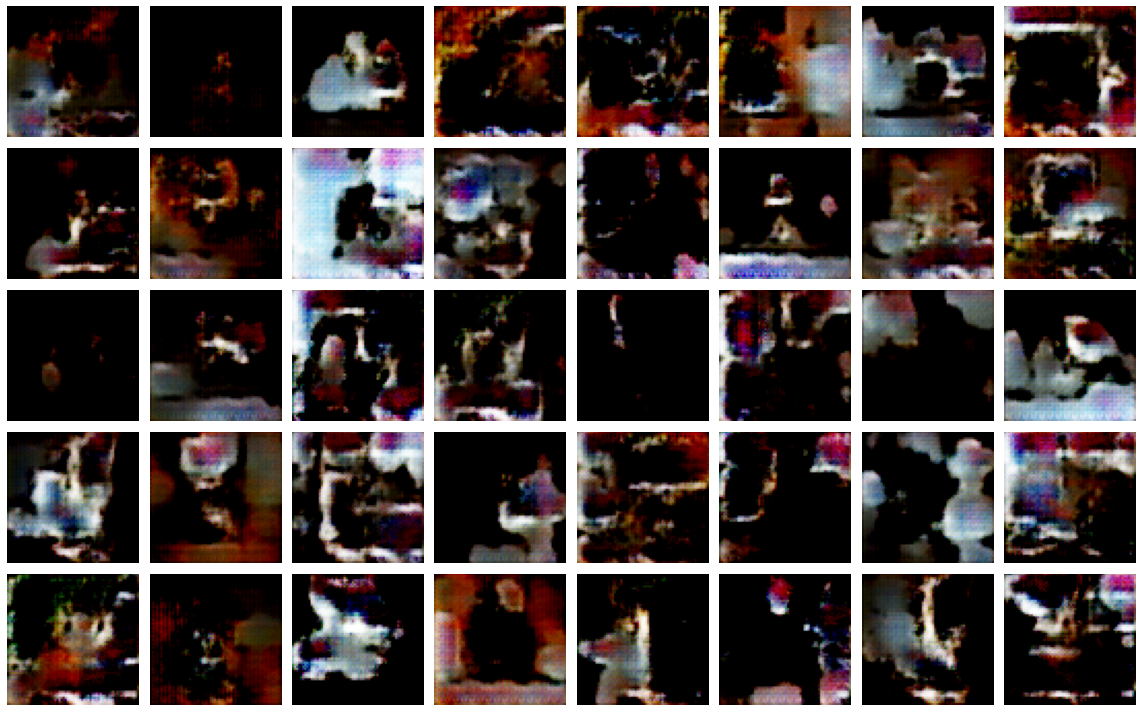

In [71]:
batch_size = 40
z_dim = 20
fixed_z = torch.randn(batch_size, z_dim)
fixed_z = fixed_z.view(fixed_z.size(0), fixed_z.size(1), 1, 1)


fake_images = G_update(fixed_z.to(device))


fig = plt.figure(figsize=(16, 10),tight_layout = True)
for i in range(0, 40):
    plt.subplot(5, 8, i+1)
    plt.imshow(fake_images[i].cpu().detach().permute(1,2,0))
    plt.axis("off")

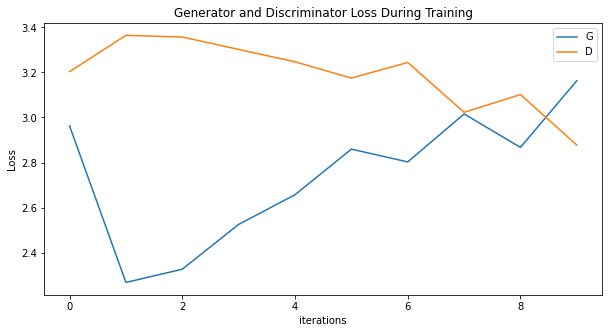

In [72]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()